<span style="font-size: 150%;color:white;background:#1155cc"> A task for the recruitment process

<span style="font-size: 150%;color:white;background:red">Wojciech Moszczyński



<span style="font-size: 300%;color:white;background:black">machine learning   
    
    from:
https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly.

Please load the data set from:
https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly.
For the first 10 products, please conduct the exploratory analysis and compute the forecast for the next 7 weeks.  

<span style="font-size: 150%;background: white;font-weight:normal;color:#1155cc"> For the first 10 products, please conduct the exploratory analysis and compute the forecast for the next 7 weeks.  

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I download data - I do not need standardized sales because the primary data is enough for me.

In [2]:
cols = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv", nrows=1).columns
df = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv", usecols=cols[:53])
df.tail()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0
810,P819,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I remember having to make a forecast for the first 10 products. The time series is too small to forecast. Only 52 values (52 weeks) is not a time series that allows you to build an effective forecasting model. In turn, there are as many as 811 products, which is a lot. This can be changed by entering the item index as a single independent variable.
Then we will get 811 times 52 variables = 42172 rows which gives a considerable number to do a forecasting model. Rule of thumb - even though I only have to forecast for the first 10 items - I am making a model for all 811 items.

In [3]:
df.shape

(811, 53)

In [4]:
df2 = df.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
df2

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">The data is complete

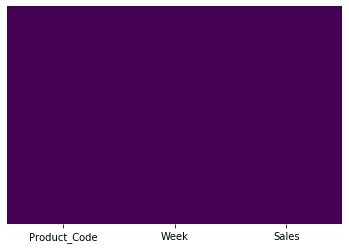

In [5]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<span style="font-size: 210%;background: white;font-weight:normal;color:#1155cc"> Removal of the letters W and P
    
<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I want to have everything in numeric format for text-based databases because I'm going to be using the data to build forecasting models.

In [6]:
df2.Product_Code = df2.Product_Code.str.replace('P', '').astype(int)
df2.Week = df2.Week.str.replace('W', '').astype(int)
df2

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0


In [7]:
df2.dtypes

Product_Code    int64
Week            int64
Sales           int64
dtype: object

max: 73
min: 0


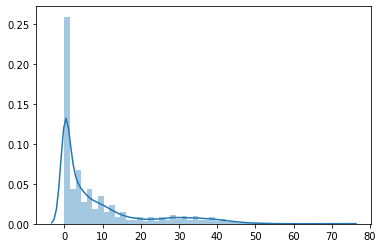

In [8]:
print('max:',df2['Sales'].max())
print('min:',df2['Sales'].min())

sns.distplot(np.array(df2['Sales']))

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">The population is not normally distributed, but I don't need to have the resultant populations in the normal distribution. It is recommended but not required. Therefore, I am not going to standardize the result variables.

In [9]:
df2.shape

(42172, 3)

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">Then we will get 811 times 52 variables = 42172 rows which gives a considerable number to do a forecasting model.

<span style="font-size: 210%;background: white;font-weight:normal;color:#1155cc"> We create additional synthetic variables
    
<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">Now I create synthetic variables, i.e. independent variables that do not exist but are made of existing independent variables. Since we have practically no variable except the week number and the commodity index, we create synthetic variables from the result variable. These variables are a shift of the price one or several weeks back and the difference between the previous and the current price.

In [10]:
df2['Sales_last_1_week'] = df2.groupby(['Product_Code'])['Sales'].shift()
df2['Sales_last_2_week'] = df2.groupby(['Product_Code'])['Sales'].shift(2)
df2['Sales_last_3_week'] = df2.groupby(['Product_Code'])['Sales'].shift(3)
df2['Sales_last_4_week'] = df2.groupby(['Product_Code'])['Sales'].shift(4)
df2['Sales_last_5_week'] = df2.groupby(['Product_Code'])['Sales'].shift(5)
df2['Sales_last_6_week'] = df2.groupby(['Product_Code'])['Sales'].shift(6)
df2['Sales_last_7_week'] = df2.groupby(['Product_Code'])['Sales'].shift(7)
df2

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week
0,1,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
42167,815,51,0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
42168,816,51,5,6.0,5.0,5.0,5.0,4.0,2.0,4.0
42169,817,51,3,4.0,0.0,0.0,0.0,2.0,2.0,0.0
42170,818,51,0,2.0,0.0,0.0,0.0,1.0,1.0,0.0


<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc"> We check if the synthetic variables 'shift' are correctly created

In [11]:
df2[df2.Week.isin([7,8,9,10,11,12,13])&(df2.Product_Code ==2)][['Product_Code',
                                                                'Sales',
                                                                'Sales_last_1_week',
                                                                'Sales_last_2_week',
                                                                'Sales_last_3_week',
                                                                'Sales_last_4_week']] 


,Product_Code,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week
5678,2,3,6.0,1.0,7.0,2.0
6489,2,3,3.0,6.0,1.0,7.0
7300,2,3,3.0,3.0,6.0,1.0
8111,2,2,3.0,3.0,3.0,6.0
8922,2,2,2.0,3.0,3.0,3.0
9733,2,6,2.0,2.0,3.0,3.0
10544,2,2,6.0,2.0,2.0,3.0


In [12]:
df2['Diff_sales_last_1_week'] = df2.groupby(['Product_Code'])['Sales_last_1_week'].diff()
df2['Diff_sales_last_2_week'] = df2.groupby(['Product_Code'])['Sales_last_2_week'].diff()
df2['Diff_sales_last_3_week'] = df2.groupby(['Product_Code'])['Sales_last_3_week'].diff()
df2['Diff_sales_last_4_week'] = df2.groupby(['Product_Code'])['Sales_last_4_week'].diff()
df2['Diff_sales_last_5_week'] = df2.groupby(['Product_Code'])['Sales_last_5_week'].diff()
df2['Diff_sales_last_6_week'] = df2.groupby(['Product_Code'])['Sales_last_6_week'].diff()
df2['Diff_sales_last_7_week'] = df2.groupby(['Product_Code'])['Sales_last_7_week'].diff()

<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc"> We check if the synthetic variables 'diff' are correctly created

In [13]:
df2[df2.Week.isin([7,8,9,10,11,12,13])&(df2.Product_Code ==4)][['Product_Code',
                                                                'Sales',
                                                                'Sales_last_1_week',
                                                                'Diff_sales_last_1_week',
                                                                'Sales_last_4_week',
                                                                'Diff_sales_last_4_week']]  

,Product_Code,Sales,Sales_last_1_week,Diff_sales_last_1_week,Sales_last_4_week,Diff_sales_last_4_week
5680,4,13,9.0,3.0,5.0,-8.0
6491,4,13,13.0,4.0,9.0,4.0
7302,4,11,13.0,0.0,6.0,-3.0
8113,4,8,11.0,-2.0,9.0,3.0
8924,4,4,8.0,-3.0,13.0,4.0
9735,4,5,4.0,-4.0,13.0,0.0
10546,4,4,5.0,1.0,11.0,-2.0


<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc"> One method of improving the quality of the model is to create a large number of synthetic variables using loops. Synthetic variables as a combination of various means, differences, shifts and logarithms. Then such a large number of independent variables can be subjected to one of the variable elimination methods. This is how you get the best synthetic variables. Since this is a verification task, I inform you that it is possible.

<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc"> We remove the poems from NaN

In [14]:
print('Before dropna:',df2.shape)
df2 = df2.dropna(how ='any')
print('After dropna: ',df2.shape)

Before dropna: (42172, 17)
After dropna:  (35684, 17)


In [15]:
df2.head(3)

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week,Diff_sales_last_5_week,Diff_sales_last_6_week,Diff_sales_last_7_week
6488,1,8,6,21.0,14.0,12.0,13.0,8.0,10.0,12.0,7.0,2.0,-1.0,5.0,-2.0,-2.0,1.0
6489,2,8,3,3.0,6.0,1.0,7.0,2.0,3.0,6.0,-3.0,5.0,-6.0,5.0,-1.0,-3.0,-1.0
6490,3,8,12,13.0,7.0,8.0,10.0,9.0,8.0,11.0,6.0,-1.0,-2.0,1.0,1.0,-3.0,4.0


<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc">Dividing time series data into training and test sets.

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I split the set for training data for the first 42 weeks, then I separate the 44 and 45 test data set. Finally, as instructed, I allow a period of 7 weeks to make a forecast for 10 products. This will be the week: 45, 46, 47, 48, 49, 50, 51, 52. I will use this data at the end of the task when I have my model ready.

In [16]:
for week in range(42,44):
    train = df2[df2['Week'] < week]   ## okres treningowy do 42 tygodnia
    val = df2[df2['Week'] == week]    ## okres testowy od 43 tygodnia włącznie do 45 tygodnia 
                                        ## 45-52 tydzień to okres super testowy 7 tygodni

    Xtrain, Xtest = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)  # podział na zmienne treningowe i testowe
    ytrain, ytest = train['Sales'].values, val['Sales'].values                  # podział na wyniki testowe i treningowe 

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">We introduce additional colors to the analysis.

In [17]:
# kolorowe wydruki
class colors:
           
    def green(self,text):
           print('\033[32m', text, '\033[0m', sep='') 

    def blue(self,text):
         print('\033[34m', text, '\033[0m', sep='')

    def magenta(self,text):
         print('\033[35m', text, '\033[0m', sep='')  

    def cyan(self,text):
         print('\033[36m', text, '\033[0m', sep='')

    def red(self,text):
         print('\033[31m', text, '\033[0m', sep='')  

    def yellow(self,text):
         print('\033[33m', text, '\033[0m', sep='')  
pass

CO = colors()

<span style="font-size: 160%;color:#1155cc">I run a set of regression models.

<span style="font-size: 110%;color:#1155cc">The goal is to choose the best model.

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import warnings   
warnings.filterwarnings("ignore")

modele = [KNeighborsRegressor(),
          DecisionTreeRegressor(),
          BaggingRegressor(),
          GradientBoostingRegressor(),
          LinearRegression(),
          AdaBoostRegressor(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          ExtraTreesRegressor(),
          RandomForestRegressor(),
          #SVR()
          ] 

nazwy = ['K-Neighbors Regressor',
          'Decision Tree Regressor',
          'Bagging Regressor',
          'Gradient Boosting Regressor',
          'Linear Regression',
          'AdaBoost Regressor',
          'Ridge',
          'Huber Regressor',
          'Elastic Net CV',
          'ExtraTreesRegressor',
          'Random Forest Regressor',
          #'Support Vector Regression'
          ]

In [19]:
def model_val(t):
    
    global mean_dev,r2
    
    kfold = model_selection.KFold(n_splits=12, random_state=148)
    mean_dev = model_selection.cross_val_score(t, Xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_error')
    mean_dev = np.round(mean_dev, decimals=1)
    r2 = model_selection.cross_val_score(t, Xtrain, ytrain, cv=kfold, scoring='r2')
    r2 = np.round(r2, decimals=2)
    
    return mean_dev,r2


K-Neighbors Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.91 0.91 0.91 0.91 0.84 0.79 0.86 0.89 0.89 0.9  0.9 ]
Mean_dev:  [-2.3 -2.3 -2.5 -2.4 -2.3 -2.9 -2.8 -2.4 -2.2 -2.1 -2.1 -2.1]


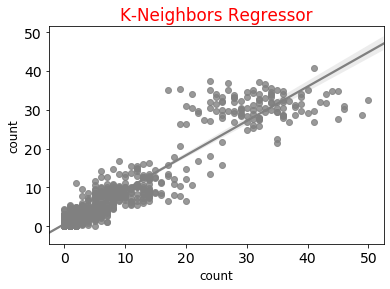

time: 4.0 seconds


Decision Tree Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.85 0.86 0.85 0.83 0.86 0.78 0.68 0.74 0.79 0.82 0.82 0.81]
Mean_dev:  [-3.2 -3.1 -3.2 -3.2 -3.1 -3.3 -3.4 -3.3 -3.  -2.7 -2.7 -2.8]


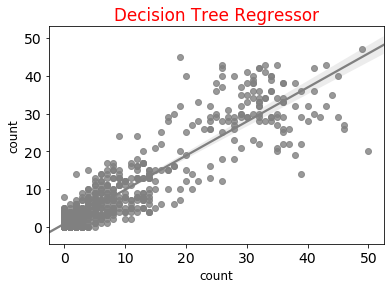

time: 5.0 seconds


Bagging Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.91 0.93 0.86 0.82 0.88 0.9  0.9  0.9  0.91]
Mean_dev:  [-2.3 -2.3 -2.3 -2.4 -2.3 -2.6 -2.7 -2.3 -2.1 -2.  -2.1 -2.1]


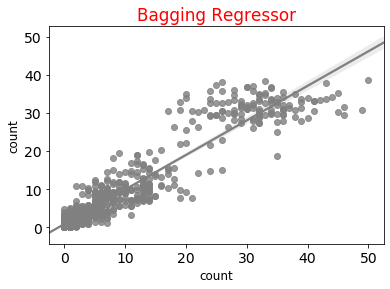

time: 30.0 seconds


Gradient Boosting Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.93 0.93 0.93 0.92 0.93 0.88 0.84 0.89 0.91 0.91 0.91 0.91]
Mean_dev:  [-2.2 -2.2 -2.3 -2.4 -2.2 -2.5 -2.4 -2.2 -2.1 -2.  -2.  -2. ]


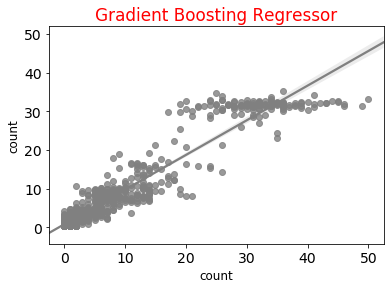

time: 76.0 seconds


Linear Regression
-------------------------------cross_val, KFold = 12 ------
R2:  [0.93 0.93 0.92 0.92 0.93 0.86 0.8  0.88 0.9  0.9  0.91 0.91]
Mean_dev:  [-2.2 -2.2 -2.3 -2.3 -2.2 -2.7 -2.8 -2.3 -2.1 -2.  -2.  -2. ]


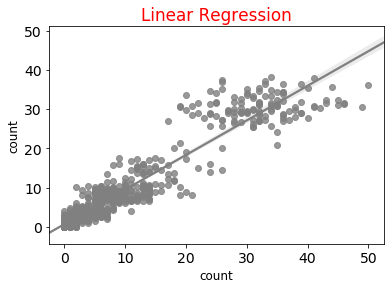

time: 1.0 seconds


AdaBoost Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.9  0.89 0.89 0.88 0.91 0.85 0.72 0.77 0.85 0.87 0.85 0.86]
Mean_dev:  [-3.4 -3.4 -3.4 -3.9 -3.3 -3.7 -4.5 -3.6 -3.6 -3.3 -3.3 -3.6]


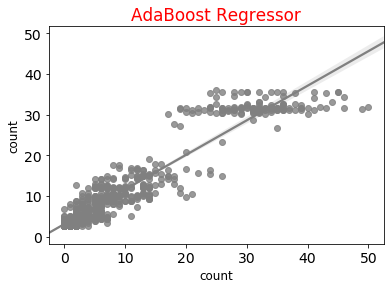

time: 43.0 seconds


Ridge
-------------------------------cross_val, KFold = 12 ------
R2:  [0.93 0.93 0.92 0.92 0.93 0.86 0.8  0.88 0.9  0.9  0.91 0.91]
Mean_dev:  [-2.2 -2.2 -2.3 -2.3 -2.2 -2.7 -2.8 -2.3 -2.1 -2.  -2.  -2. ]


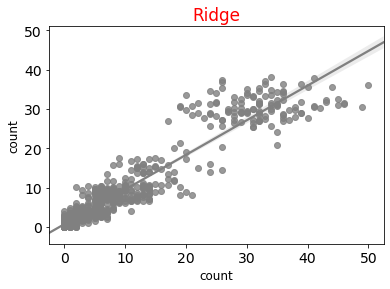

time: 0.0 seconds


Huber Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.93 0.92 0.92 0.93 0.86 0.81 0.88 0.9  0.9  0.91 0.91]
Mean_dev:  [-2.2 -2.2 -2.3 -2.3 -2.1 -2.6 -2.7 -2.2 -2.1 -2.  -2.  -2. ]


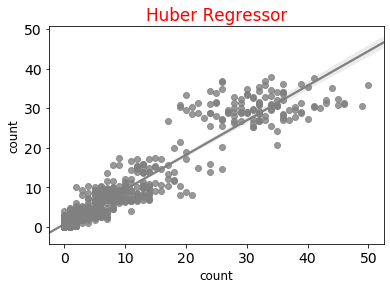

time: 9.0 seconds


Elastic Net CV
-------------------------------cross_val, KFold = 12 ------
R2:  [0.93 0.93 0.92 0.92 0.93 0.86 0.81 0.88 0.9  0.9  0.91 0.91]
Mean_dev:  [-2.2 -2.2 -2.3 -2.3 -2.2 -2.7 -2.8 -2.3 -2.2 -2.  -2.  -2. ]


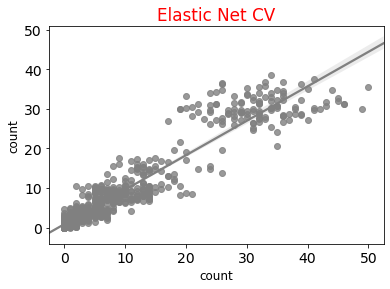

time: 7.0 seconds


ExtraTreesRegressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.93 0.93 0.93 0.92 0.93 0.88 0.83 0.88 0.91 0.91 0.91 0.91]
Mean_dev:  [-2.2 -2.2 -2.3 -2.3 -2.1 -2.5 -2.6 -2.3 -2.1 -2.  -2.  -2. ]


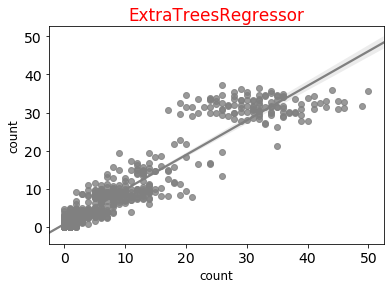

time: 159.0 seconds


Random Forest Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.93 0.93 0.93 0.92 0.93 0.87 0.83 0.89 0.91 0.91 0.91 0.91]
Mean_dev:  [-2.2 -2.2 -2.3 -2.3 -2.1 -2.5 -2.5 -2.2 -2.  -2.  -2.  -2. ]


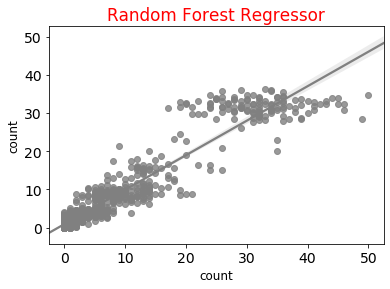

time: 289.0 seconds



In [20]:
for n,p in zip(nazwy,modele):      
    
    import matplotlib.pyplot as plt
    import time   
    
    start_time = time.time()
    
    results = model_val(p)
    print()
    CO.red(n)
    print("-------------------------------cross_val, KFold = 12 ------")
    print('R2: ', r2)
    print('Mean_dev: ', mean_dev)
    
    # wykres 
    plt.rc("font",size=14)
    clf = p
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xtest)

    ax = sns.regplot(ytest,ypred,color='grey')
    plt.title(n,color='r') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()
    
    # pomiar czasu
    n = (time.time() - start_time)
    n = np.round(n)
    CO.cyan('time: %s seconds' % n)    
    print()

<span style="font-size: 160%;color:#1155cc">Finding optimal hyperparameters - optimization of forecasting models.

<span style="font-size: 110%;color:#1155cc">We have many models in default settings. Cross-validation showed the predictive quality of the models. Now we can choose the model that best forecasts according to r2 and optimize this model by selecting the best hyperparameters.
I chose the Linear Regression model because it is good and its optimization takes only 4 seconds. The Random Forest Regressor model seems to be better, but its optimization takes over 10 minutes.

 <span style="font-size: 150%;color:white;background:#1155cc"> Optimization of the selected model: Linear Regression</span> <span style="font-size: 150%;color:white;background:RED"> 4 sekundy

Linear Regression: 0.8976616070664007
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
LinearRegression(fit_intercept=False, normalize=True)


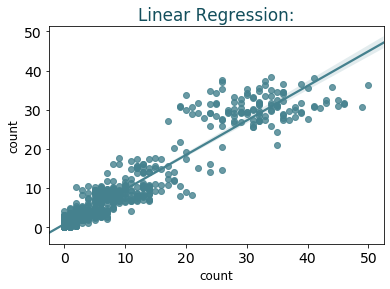

time: 1.0 seconds


In [21]:
#from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import time   
    
start_time = time.time()


parameters = [{'fit_intercept': [True, False], 'normalize': [True, False],'copy_X': [True, False]}]



Linear_Regression = GridSearchCV(LinearRegression(), parameters)
Linear_Regression.fit(Xtrain,ytrain)


print('Linear Regression:',Linear_Regression.best_score_)
print(Linear_Regression.best_params_)
print(Linear_Regression.best_estimator_)

    # wykres
    
plt.rc("font",size=14)
Linear_Regression.fit(Xtrain,ytrain)
ypred = Linear_Regression.predict(Xtest)

ax = sns.regplot(ytest,ypred,color='#45818e')
plt.title('Linear Regression:',color='#134f5c') 
plt.ylabel('count', fontsize=12) 
plt.xlabel('count', fontsize=12) 
plt.show()


# pomiar czasu
n = (time.time() - start_time)
n = np.round(n)
print('time: %s seconds' % n)  

<span style="font-size: 150%;color:white;background:#1155cc"> Optimization of the selected model: 'Random Forest Regressor'</span> <span style="font-size: 150%;color:white;background:RED"> 613 sekund 

<span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja 'Ridge'</span> <span style="font-size: 150%;color:white;background:RED"> 4 sekundy

Ridge: 0.8976616117850907
{'fit_intercept': False, 'normalize': True}
Ridge(fit_intercept=False, normalize=True)


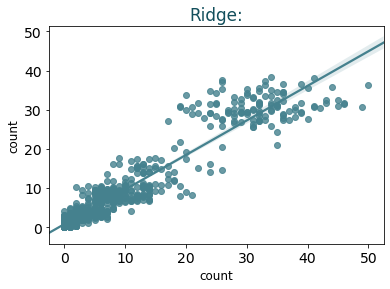

time: 1.0 seconds


In [22]:
#from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
import time   
    
start_time = time.time()


parameters = [{
  'fit_intercept' : [True, False],
 'normalize': [True, False]
 }]



Ridge = GridSearchCV(Ridge(), parameters)
Ridge.fit(Xtrain,ytrain)


print('Ridge:',Ridge.best_score_)
print(Ridge.best_params_)
print(Ridge.best_estimator_)

    # wykres
    
plt.rc("font",size=14)
Ridge.fit(Xtrain,ytrain)
ypred = Ridge.predict(Xtest)

ax = sns.regplot(ytest,ypred,color='#45818e')
plt.title('Ridge:',color='#134f5c') 
plt.ylabel('count', fontsize=12) 
plt.xlabel('count', fontsize=12) 
plt.show()


# pomiar czasu
n = (time.time() - start_time)
n = np.round(n)
print('time: %s seconds' % n)  

 <span style="font-size: 150%;color:white;background:#1155cc"> Optimization of the selected model: GradientBoostingRegressor</span> <span style="font-size: 150%;color:white;background:RED"> 239 sekund

<span style="font-size: 150%;color:white;background:#1155cc"> Optimization of the selected model: 'Extra Trees Regressor'</span> <span style="font-size: 150%;color:white;background:RED"> 544 sekundy 

<span style="font-size: 150%;color:white;background:#1155cc"> Optimization of the selected model: 'ElasticNetCV()'</span> <span style="font-size: 150%;color:white;background:RED"> 717 sekund 

 <span style="font-size: 200%;color:white;background:#674ea7"> CHECKING HOW THE SELECTED MODEL IS FORECASTING ON STANDARD DATA 
    
<span style="font-size: 160%;color:white;background:RED"> IF IT IS NOT OVERFITTING?
    
<span style="font-size: 110%;color:#1155cc">As instructed, I make a 7-week forecast for the first 10 products.

In [23]:
# K_Neighbors_Regressor,
# DecisionTreeRegressor,
# Bagging_Regressor,
# Gradient_Boosting_Regressor,
# Linear_Regression.predict(Xtest)
# Ada_Boost_Regressor, 
#clf
# Ridge
# Linear_Regression

model = Ridge      # TU WPISUJEMY MODEL PO OPTYMALIZACJI

In [24]:
def ModVal(model):

    from sklearn.model_selection import cross_val_score 

    ypred_tr = model.predict(Xtrain)

    r2_train = cross_val_score(model,Xtrain,ytrain, cv=12)
    r2_train = np.round(r2_train, decimals=2)
    print('r2 train:', r2_train)

    ax = sns.regplot(ytrain,ypred_tr,color='#741b47')
    plt.title('Model_train',color='#741b47') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()


    r2_test = cross_val_score(model,Xtest,ytest, cv=12)
    r2_test = np.round(r2_test, decimals=2)
    print('r2 testowy:', r2_test)

    ypred_te = model.predict(Xtest)

    ax = sns.regplot(ytest,ypred_te,color='#1155cc')
    plt.title('Model_test',color='#1155cc') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()


r2 train: [0.93 0.93 0.92 0.92 0.93 0.86 0.8  0.88 0.9  0.9  0.91 0.91]


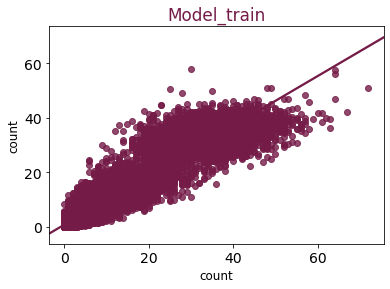

r2 testowy: [0.83 0.85 0.82 0.9  0.67 0.91 0.82 0.67 0.77 0.85 0.63 0.73]


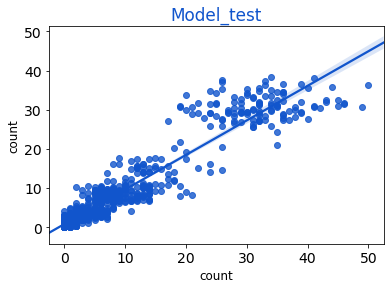

In [25]:
ModVal(model)

<span style="font-size: 160%;background: white;color:#1155cc">We save the selected model to disk
    
<span style="font-size: 110%;background: white;color:#1155cc">It is not necessary, but it wants to show that we can transfer the extracted model to another device and use this model effectively.

In [26]:
import joblib

#RFC = RandomForestClassifier()
#RFC.fit(X_train, y_train) 

filename ='/home/wojciech/Pulpit/6/model_AA.pkl' 

# zapisanie
_ = joblib.dump(model, filename, compress=9)

<span style="font-size: 110%;background: white;color:#1155cc">We open the selected model from the disk

In [27]:
# otwarcie z dysku
model_AA = joblib.load(filename) 
model_AA

GridSearchCV(estimator=Ridge(),
             param_grid=[{'fit_intercept': [True, False],
                          'normalize': [True, False]}])

<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc"> I choose quotes from the period 46-52 weeks is a super test period (7 weeks)

In [28]:
SuperTest = df2[df2.Week.isin([45,46,47,48,49,50,51,52])] 
SuperTest.head(4)

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week,Diff_sales_last_5_week,Diff_sales_last_6_week,Diff_sales_last_7_week
36495,1,45,10,8.0,7.0,4.0,11.0,7.0,17.0,12.0,1.0,3.0,-7.0,4.0,-10.0,5.0,3.0
36496,2,45,1,5.0,4.0,2.0,5.0,2.0,3.0,7.0,1.0,2.0,-3.0,3.0,-1.0,-4.0,5.0
36497,3,45,5,5.0,14.0,6.0,5.0,3.0,9.0,12.0,-9.0,8.0,1.0,2.0,-6.0,-3.0,0.0
36498,4,45,4,3.0,10.0,9.0,6.0,12.0,8.0,8.0,-7.0,1.0,3.0,-6.0,4.0,0.0,2.0


<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc">Only the first 10 products

In [29]:
SuperTest = SuperTest[SuperTest['Product_Code']<=10]
SuperTest.head(4)

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week,Diff_sales_last_5_week,Diff_sales_last_6_week,Diff_sales_last_7_week
36495,1,45,10,8.0,7.0,4.0,11.0,7.0,17.0,12.0,1.0,3.0,-7.0,4.0,-10.0,5.0,3.0
36496,2,45,1,5.0,4.0,2.0,5.0,2.0,3.0,7.0,1.0,2.0,-3.0,3.0,-1.0,-4.0,5.0
36497,3,45,5,5.0,14.0,6.0,5.0,3.0,9.0,12.0,-9.0,8.0,1.0,2.0,-6.0,-3.0,0.0
36498,4,45,4,3.0,10.0,9.0,6.0,12.0,8.0,8.0,-7.0,1.0,3.0,-6.0,4.0,0.0,2.0


In [30]:
SuperTest['Product_Code'].value_counts()

10    7
9     7
8     7
7     7
6     7
5     7
4     7
3     7
2     7
1     7
Name: Product_Code, dtype: int64

max: 24
min: 0


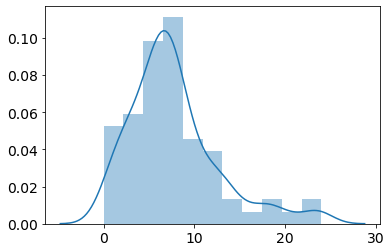

In [31]:
print('max:',SuperTest['Sales'].max())
print('min:',SuperTest['Sales'].min())

sns.distplot(np.array(SuperTest['Sales']))

In [32]:
from sklearn.model_selection import train_test_split 

y = SuperTest['Sales']
X = SuperTest.drop('Sales', axis=1)

#Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.25, random_state = 148)

In [33]:
model = model_AA
model

GridSearchCV(estimator=Ridge(),
             param_grid=[{'fit_intercept': [True, False],
                          'normalize': [True, False]}])

<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc">Operation of the selected model for the first 10 products for 7 weeks

r2 train: [ 0.3  0.5  0.2  0.2  0.7 -0.1  0.8  0.3  0.6  0.7  0.7  0.8]


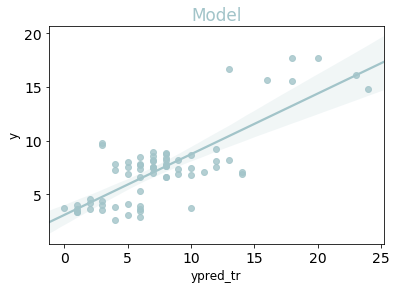

In [34]:
from sklearn.model_selection import cross_val_score 

ypred_tr = model_AA.predict(X)

r2_train = cross_val_score(model_AA,X,y, cv=12)
r2_train = np.round(r2_train, decimals=1)
print('r2 train:', r2_train)

ax = sns.regplot(y,ypred_tr,color='#a2c4c9')
plt.title('Model',color='#a2c4c9') 
plt.ylabel('y', fontsize=12) 
plt.xlabel('ypred_tr', fontsize=12) 
plt.show()

In [35]:
ypred_tr

array([ 8.6714086 ,  3.97498004,  7.96710694,  7.25497064,  7.54306625,
        3.55282113,  3.59953708,  7.64689169,  9.78100956, 14.78561486,
        9.18979829,  3.38098853,  6.94814139,  6.65314841,  8.49897115,
        3.41448912,  4.21499943,  7.79560468,  8.11374863, 16.65421118,
        9.62289845,  2.61938589,  6.58672315,  6.61854382,  7.73712328,
        4.12519118,  3.88249132,  7.86430931,  7.58051152, 15.62078867,
        7.42906464,  3.04127474,  6.88946866,  7.04359618,  7.52135766,
        4.40936613,  4.51515951,  7.55869015,  7.44650733, 15.53762394,
        7.35646965,  3.65014955,  8.83873557,  8.40983572,  7.11381091,
        3.98664304,  3.81502228,  7.77859929,  8.13804381, 16.10949479,
        6.87256523,  2.90388737,  8.70965295,  8.22331289,  8.20705067,
        3.71835458,  3.66891005,  6.89855882,  8.97372209, 17.72258798,
        6.79294512,  3.71732611,  8.55240662,  7.66267439,  8.21097147,
        5.27051758,  3.36844904,  7.3154282 ,  8.23914503, 17.72

In [36]:
df11 = pd.DataFrame(ypred_tr).round(0)
df11.columns = ['y_model']
df11.head(5)

,y_model
0,9.0
1,4.0
2,8.0
3,7.0
4,8.0


In [37]:
print('df11     ',df11.shape)
print('y        ',y.shape)
print('SuperTest',SuperTest.shape)

df11      (70, 1)
y         (70,)
SuperTest (70, 17)


In [38]:
SuperTest=SuperTest.reset_index()
SuperTest=SuperTest.drop(['index'],axis=1)

In [39]:
SuperTest.columns

Index(['Product_Code', 'Week', 'Sales', 'Sales_last_1_week',
       'Sales_last_2_week', 'Sales_last_3_week', 'Sales_last_4_week',
       'Sales_last_5_week', 'Sales_last_6_week', 'Sales_last_7_week',
       'Diff_sales_last_1_week', 'Diff_sales_last_2_week',
       'Diff_sales_last_3_week', 'Diff_sales_last_4_week',
       'Diff_sales_last_5_week', 'Diff_sales_last_6_week',
       'Diff_sales_last_7_week'],
      dtype='object')

<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc">I compare the forecast with the execution

In [40]:
Super_NOWA = pd.merge(SuperTest,df11, how='inner', left_index=True, right_index=True)
Super_NOWA[['Product_Code','Week','Sales','y_model']]

,Product_Code,Week,Sales,y_model
0,1,45,10,9.0
1,2,45,1,4.0
2,3,45,5,8.0
3,4,45,4,7.0
4,5,45,12,8.0
...,...,...,...,...
65,6,51,6,5.0
66,7,51,1,3.0
67,8,51,9,7.0
68,9,51,13,8.0


Text(0.5, 1.0, 'COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

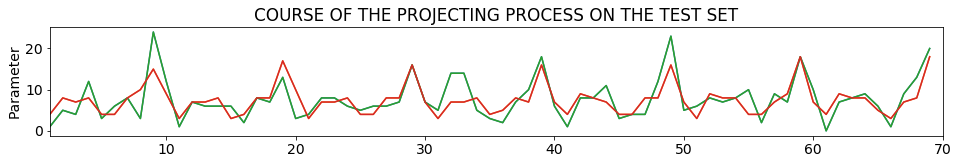

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(16, 2))
for ewa in ['Sales', 'y_model']:
    ax.plot(Super_NOWA[['Sales', 'y_model']], label=ewa)
    
ax.set_xlim(1, 70)
#ax.legend()
ax.set_ylabel('Parameter')
ax.set_title('COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc"> To improve the prediction, you can use a model that requires more computational effort (longer model optimization time) or run many models and make a model committee from many different predictions. All of this could improve the accuracy of the model, but it costs more computational time.